# Paper *Self-Supervised Generalisation with Meta Auxiliary Learning*

https://papers.nips.cc/paper/2019/file/92262bf907af914b95a0fc33c3f33bf6-Paper.pdf

Using an auxiliary loss is called auxiliary learning, and is similar to multi-task learning, except that only the primary task is of interest. In our case, the primary task is to output whether image 1 is a digit smaller than image 2. The role of the auxiliary task is to assist in generalization of this primary task.

This paper discusses unsupervised auxiliary learning, for the cases when no label exist for the auxiliary task. Note: this is not our case, we have the original labels $\{0, 1, \dots, 9\}$ from which we deduce the boolean value. Also, the project presentation PDF mentions:

> For the [auxiliary loss], the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest. 


# Google paper "Going deeper with convolutions"

https://arxiv.org/abs/1409.4842

https://stats.stackexchange.com/questions/304699/what-is-auxiliary-loss-as-mentioned-in-pspnet-paper



The paper from Google introduced the concept of auxiliary loss. But the focus is to improve very deep networks (they describe a 22-layer long network), whereas we don't really have deep networks for our simple task. The basic idea is to add **auxiliary classifiers connected to intermediate layers**. This is especially useful to **fight gradient vanishing and add regularization**.

### Structure of extra network

1. Average pooling layer
1. 1x1 convolution for dimension reduction and relu activation
1. fully connected and relu
1. dropout (70%)
1. linear layer with softmax loss as classifier

# Draft ideas for Project 1

Based on this [medium article](https://towardsdatascience.com/improve-your-neural-networks-generalization-performance-by-adding-an-unsupervised-auxiliary-loss-4d58b2dead54), we can combine the main loss with the auxiliary loss for the total loss:

$$\text{total loss} = \text{main loss} + \lambda \cdot \text{auxiliary loss}$$

Also, since our network is *not* deep (and can't be, because computations must be rather fast as mentionned in the project description), we should probably put the auxiliary classifier at the end of the network, and not at intermediate levels (as done in Google paper). 

Also, we must combine the main and auxiliary loss in a meaningful way:

* Main loss is currently an accuracy 
* Auxiliary loss would probably be categorical cross entropy

We should probably change the main loss to something more related to the multi-class entropy. 

# Implementation

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

## dataset build

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-10 13:18:28--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-10 13:18:28--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [            <=>     ]  33.20M  9.75MB/s    in 4.3s    

2021-03-10 13:18:33 (7.77 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]



In [3]:
!tar -xf MNIST.tar.gz


In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [5]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [6]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

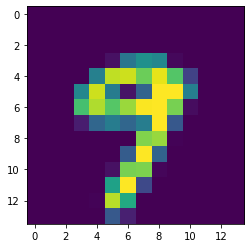

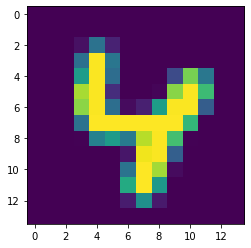

train shape : torch.Size([1000, 2, 14, 14])


In [7]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [8]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


# Fully dense net with aux loss


In [9]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

In [10]:
class FullyDenseNetAux(nn.Module):
    def __init__(self):
        super(FullyDenseNetAux, self).__init__()

        # Network basis: common for all losses
        # 14 * 14 = 196
        self.fc1_im1 = nn.Linear(14*14, 100)
        self.fc1_im2 = nn.Linear(14*14, 100)
        
        self.fc2_im1 = nn.Linear(100, 50)
        self.fc2_im2 = nn.Linear(100, 50)
        
        # Auxiliary networks
        self.fc3_im1 = nn.Linear(50, 10)
        self.fc3_im2 = nn.Linear(50, 10)
        
        # Main task
        self.fc4 = nn.Linear(2*50, 10)
        self.fc5 = nn.Linear(10, 1)

    def forward(self, x):
        im1 = nn.Flatten()(x[:, 0, :, :])
        im2 = nn.Flatten()(x[:, 1, :, :])
        
        im1 = torch.relu(self.fc1_im1(im1))
        im2 = torch.relu(self.fc1_im2(im2))
        
        im1 = torch.relu(self.fc2_im1(im1))
        im2 = torch.relu(self.fc2_im2(im2))
        
        # Main task
        common = torch.cat((im1, im2), dim=1)
        common = torch.relu(self.fc4(common))
        common = self.fc5(common)
        common = F.sigmoid(common)
        
        # Auxiliary networks
        im1 = self.fc3_im1(im1)
        im1 = F.softmax(im1)
        
        im2 = self.fc3_im2(im2)
        im2 = F.softmax(im2)
        
        return common, im1, im2

# Train tools

In [11]:
def custom_loss(output, target, classes, lambda_=1.0):
  """
  Custom loss for network with auxiliary losses. The total loss is a combination
  of the loss of the main task (binary cross entropy) and the negative log likelihood
  for the two auxiliary tasks. Importance of auxiliary losses is controlled by
  the `lambda_` hyperparameter.
  """
  main, im1, im2 = output

  main_loss = F.binary_cross_entropy(main.flatten(), target)
  aux_loss_1 = F.nll_loss(im1, classes[:, 0])
  aux_loss_2 = F.nll_loss(im2, classes[:, 1])

  return main_loss + lambda_ * (aux_loss_1 + aux_loss_2)

In [12]:
def handle_loss(criterion):
  """
  Handle the fact that the network with auxiliary loss has three-item tuple output,
  which needs to be treated separately to compute the loss and the accuracy.
  """
  if criterion is not custom_loss:
    internal_criterion = lambda output, target, _: criterion(output.flatten(), target)
    compute_acc = lambda output, target: (target == torch.round(output.flatten()) ).sum().item()
  else:
    internal_criterion = criterion
    compute_acc = lambda output, target: (target == torch.round(output[0].flatten()) ).sum().item()
    
  return internal_criterion, compute_acc

In [13]:
def train_epoch(network_ , optimizer_ , criterion = F.binary_cross_entropy ):
  internal_criterion, compute_acc = handle_loss(criterion)
    
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data)
    loss = internal_criterion(output, target.to(torch.float32), classes)
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( compute_acc(output, target) )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [14]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  internal_criterion, compute_acc = handle_loss(criterion_)

  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += internal_criterion(output, target.to(torch.float32), classes)
      acc += compute_acc(output, target)

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [15]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, f'{train_loss:.4}\t{train_acc:.4}\t{test_loss:.4}\t{test_acc:.4}')

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

# stats

In [16]:
def train_multiple_runs( network_class , runs = 10 , epoch = 30):
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = [],[],[],[]
  
  for i in range(runs):
    n = network_class()
    optimizer = optim.SGD(n.parameters(), lr=0.01, momentum=0.5)
    criterion = F.binary_cross_entropy

    tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(n , optimizer , criterion , epoch , debug_ = False)
    all_train_loss.append(tot_train_loss)
    all_train_acc.append(tot_train_acc)
    all_test_loss.append(tot_test_loss)
    all_test_acc.append(tot_test_acc)

  return all_train_loss , all_train_acc , all_test_loss , all_test_acc

In [17]:
def plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc ):
  epochs = range(1, len(tot_train_loss)+1 )
  plt.plot(epochs, tot_train_loss, 'g', label='Training loss')
  plt.plot(epochs, tot_test_loss, 'b', label='Test loss')
  plt.plot(epochs, tot_train_acc, 'r', label='Training acc')
  plt.plot(epochs, tot_test_acc, 'y', label='Test acc')
  plt.title('Training and Test loss/acc')
  plt.xlabel('Epochs')
  plt.ylabel('loss/acc')
  plt.ylim((0,1))
  plt.legend()
  plt.show()

In [18]:
import numpy as np
def plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc):
  trl_mean = np.array(all_train_loss).mean(axis = 0)
  tel_mean = np.array(all_train_acc).mean(axis = 0)
  tra_mean = np.array(all_test_loss).mean(axis = 0)
  tea_mean = np.array(all_test_acc).mean(axis = 0)

  trl_std = np.array(all_train_loss).std(axis = 0)
  tel_std = np.array(all_train_acc).std(axis = 0)
  tra_std = np.array(all_test_loss).std(axis = 0)
  tea_std = np.array(all_test_acc).std(axis = 0)

  epochs = range(1, len(tea_std)+1 )

  temp = [ [trl_mean , trl_std] , [tel_mean , tel_std] , [tra_mean , tra_std] , [tea_mean , tea_std] ]

  for g in temp : 
    plt.plot( epochs , g[0] )
    plt.fill_between(epochs, g[0]-g[1], g[0]+g[1] ,alpha=0.3)

  plt.ylim((-0.1,1.1))


# Auxiliary task

In [19]:
net = FullyDenseNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, F.binary_cross_entropy)

0 0.6525	0.627	0.5652	0.703
1 0.4963	0.76	0.5316	0.728
2 0.4133	0.814	0.5077	0.745
3 0.3569	0.851	0.4974	0.747
4 0.3052	0.873	0.5941	0.734
5 0.3377	0.848	0.4788	0.76
6 0.3085	0.877	1.041	0.595
7 0.32	0.871	0.5748	0.744
8 0.2087	0.926	0.6243	0.738
9 0.1598	0.949	0.6571	0.738
10 0.1265	0.96	0.7616	0.73
11 0.1085	0.972	0.7549	0.74
12 0.1204	0.958	0.6259	0.766
13 0.3735	0.871	0.484	0.759
14 0.1763	0.935	0.5144	0.775
15 0.07723	0.984	0.6357	0.766
16 0.05384	0.995	0.6335	0.774
17 0.04367	0.995	0.6612	0.775
18 0.03421	0.996	0.568	0.79
19 0.02069	0.999	0.6022	0.801
20 0.01305	1.0	0.5996	0.793
21 0.0084	1.0	0.6246	0.798
22 0.006985	1.0	0.6442	0.801
23 0.005928	1.0	0.66	0.801
24 0.005087	1.0	0.675	0.801
25 0.004406	1.0	0.684	0.802
26 0.003828	1.0	0.6927	0.802
27 0.003371	1.0	0.7002	0.804
28 0.003002	1.0	0.7064	0.803
29 0.002688	1.0	0.7131	0.803


In [20]:
net = FullyDenseNetAux()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(net, optimizer, criterion_=custom_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0 0.2192	0.625	-0.2691	0.746
1 -0.3732	0.775	-0.4965	0.768
2 -0.6086	0.816	-0.5811	0.772
3 -0.7649	0.842	-0.6912	0.79
4 -0.878	0.851	-0.7378	0.79
5 -0.9851	0.884	-0.6143	0.762
6 -1.066	0.901	-0.8328	0.795
7 -1.079	0.883	-0.8267	0.787
8 -1.125	0.882	-0.7682	0.768
9 -1.178	0.896	-0.8004	0.768
10 -1.257	0.94	-0.8388	0.798
11 -1.34	0.975	-0.8851	0.803
12 -1.395	0.982	-0.8797	0.81
13 -1.432	0.992	-0.8561	0.811
14 -1.448	0.991	-0.847	0.814
15 -1.466	0.994	-0.8303	0.813
16 -1.476	0.996	-0.8159	0.818
17 -1.492	0.998	-0.7545	0.814
18 -1.499	0.998	-0.7349	0.811
19 -1.502	0.997	-0.7806	0.827
20 -1.517	1.0	-0.7193	0.816
21 -1.523	1.0	-0.7627	0.819
22 -1.528	1.0	-0.7713	0.814
23 -1.528	1.0	-0.7544	0.822
24 -1.538	0.999	-0.7401	0.821
25 -1.556	1.0	-0.7252	0.807
26 -1.579	1.0	-0.7555	0.815
27 -1.596	1.0	-0.7601	0.813
28 -1.611	1.0	-0.7514	0.813
29 -1.619	1.0	-0.7646	0.821
